In [1]:
import numpy as np
import scipy.stats as stats
import scipy.optimize as optimize
from scipy.special import gamma
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def studentpdf(epsilon, nu):
    if nu <= 2: 
        return 0
    return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)

def garch(mu, omega, alpha, beta, returns):
    T = len(returns)
    sigma_squared = np.zeros(T)
    sigma_squared[0] = omega / (1 - alpha - beta)
    for t in range(1, T):
        sigma_squared[t] = omega + alpha * (returns[t - 1] - mu) ** 2 + beta * sigma_squared[t - 1]
    return sigma_squared

def negative_log_likelihood_garch(parameters, returns):
    mu, omega, alpha, beta, nu = parameters
    sigmasquared = garch(mu, omega, alpha, beta, returns)
    epsilon = (returns - mu) / np.sqrt(sigmasquared + 1e-8)
    ll = -np.log(np.sqrt(sigmasquared + 1e-8)) + np.log(studentpdf(epsilon, nu))
    return -np.sum(ll)

In [3]:
def asymmetric_garch(mu, omega, alpha_pos, alpha_neg, beta, returns):
    T = len(returns)
    sigma_squared = np.zeros(T)
    initial_divisor = 1 - beta - alpha_pos / 2 - alpha_neg / 2
    sigma_squared[0] = omega / initial_divisor
    for t in range(1, T):
        epsilon_t = (returns[t-1] - mu)
        shock_effect = alpha_pos * (epsilon_t**2) if epsilon_t >= 0 else alpha_neg * (epsilon_t**2)
        sigma_squared[t] = omega + shock_effect + beta * sigma_squared[t-1]
    return sigma_squared

def neg_log_likelihood_asymmetric_garch(parameters, returns):
    mu, omega, alpha_pos, alpha_neg, beta, nu = parameters
    sigma_squared = asymmetric_garch(mu, omega, alpha_pos, alpha_neg, beta, returns)
    epsilon = (returns - mu) / np.sqrt(sigma_squared + 1e-8)
    ll = -np.log(np.sqrt(sigma_squared + 1e-8)) + np.log(studentpdf(epsilon, nu))
    return -np.sum(ll)

In [4]:
def asymmetric_beta_t_egarch(parameters, returns):
    mu, lam, phi, kappa, k_tilde, nu = parameters
    T = len(returns)
    lambda_t = np.zeros(T)
    lambda_t[0] = lam  # Starting value for lambda

    for t in range(1, T):
        epsilon_t = (returns[t-1] - mu) / np.exp(lambda_t[t-1])
        u_t = np.sqrt((nu + 3) / (2 * nu)) * ((nu + 1) / (nu - 2 + epsilon_t**2) * epsilon_t**2 - 1)
        v_t = np.sqrt(((nu - 2) * (nu + 3)) / (nu * (nu + 1))) * ((nu + 1) / (nu - 2 + epsilon_t**2 + 1e-8) * epsilon_t)
        lambda_t[t] = lam * (1 - phi) + phi * lambda_t[t-1] + kappa * u_t + k_tilde * v_t

    sigmas = np.exp(lambda_t)
    return sigmas

def negative_log_likelihood_asymetric_beta_t_egarch(parameters, returns):
    mu, lam, phi, kappa, k_tilde, nu = parameters
    sigmas = asymmetric_beta_t_egarch(parameters, returns)
    epsilon = (returns - mu) / np.sqrt(sigmas + 1e-8)
    log_likelihood = -np.log(np.sqrt(sigmas + 1e-8)) + np.log(studentpdf(epsilon, nu))
    return -np.sum(log_likelihood)

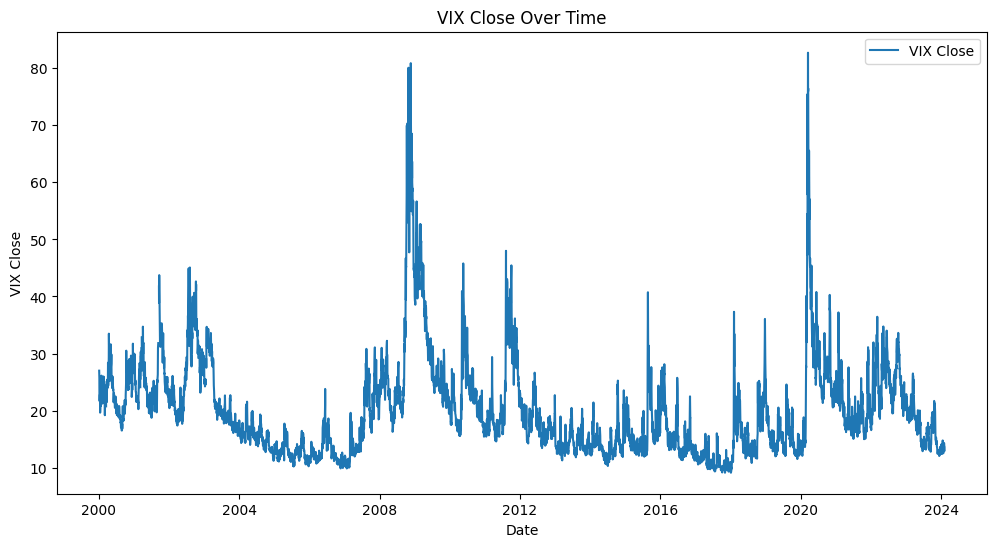

In [5]:
data = pd.read_excel('data.xlsx', index_col='date', parse_dates=True)
returns = data['close-to-close log  return'].values
dates = pd.to_datetime(data.index, format='%Y%m%d')

# Plot VIX
plt.figure(figsize=(12, 6))
plt.plot(data['VIX close'], label='VIX Close')
plt.legend()
plt.title('VIX Close Over Time')
plt.xlabel('Date')
plt.ylabel('VIX Close')
plt.show()


# Symmetric GARCH

/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_98953/615677109.py:17: RuntimeWarning: invalid value encountered in sqrt
  epsilon = (returns - mu) / np.sqrt(sigmasquared + 1e-8)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_98953/615677109.py:18: RuntimeWarning: invalid value encountered in sqrt
  ll = -np.log(np.sqrt(sigmasquared + 1e-8)) + np.log(studentpdf(epsilon, nu))


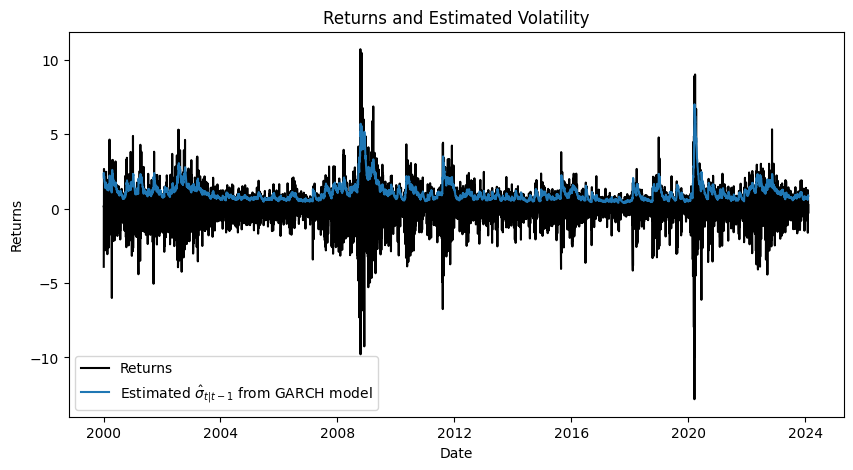

Optimization Successful: Yes
Estimated Parameters:
  mu    : 0.076
  omega : 0.013
  alpha : 0.121
  beta  : 0.876
  nu    : 6.470
Log-Likelihood: -8211.3


In [6]:
# Optimization setup
initial_values = [np.mean(returns), np.var(returns) / 20, 0.10, 0.88, 6]
bounds = [(None, None), (0, None), (0, None), (0, None), (2, 40)]
result = optimize.minimize(negative_log_likelihood_garch, initial_values, args=(returns,), bounds=bounds, method='Nelder-Mead')

# Extract optimized parameters
mu_hat, omega_hat, alpha_hat, beta_hat, nu_hat = result.x
log_likelihood = -result.fun
sigmasquared = garch(mu_hat, omega_hat, alpha_hat, beta_hat, returns)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(dates, returns, 'k', label='Returns')
plt.plot(dates, np.sqrt(sigmasquared), label='Estimated $\hat{\sigma}_{t|t-1}$ from GARCH model')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Returns and Estimated Volatility')
plt.show()

print(f"Optimization Successful: {'Yes' if result.success else 'No'}")
print("Estimated Parameters:")
print(f"  mu    : {mu_hat:.3f}")
print(f"  omega : {omega_hat:.3f}")
print(f"  alpha : {alpha_hat:.3f}")
print(f"  beta  : {beta_hat:.3f}")
print(f"  nu    : {nu_hat:.3f}")

print(f"Log-Likelihood: {log_likelihood:.1f}")

# Asymmetric GARCH

/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_98953/723836336.py:15: RuntimeWarning: invalid value encountered in sqrt
  epsilon = (returns - mu) / np.sqrt(sigma_squared + 1e-8)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_98953/723836336.py:16: RuntimeWarning: invalid value encountered in sqrt
  ll = -np.log(np.sqrt(sigma_squared + 1e-8)) + np.log(studentpdf(epsilon, nu))


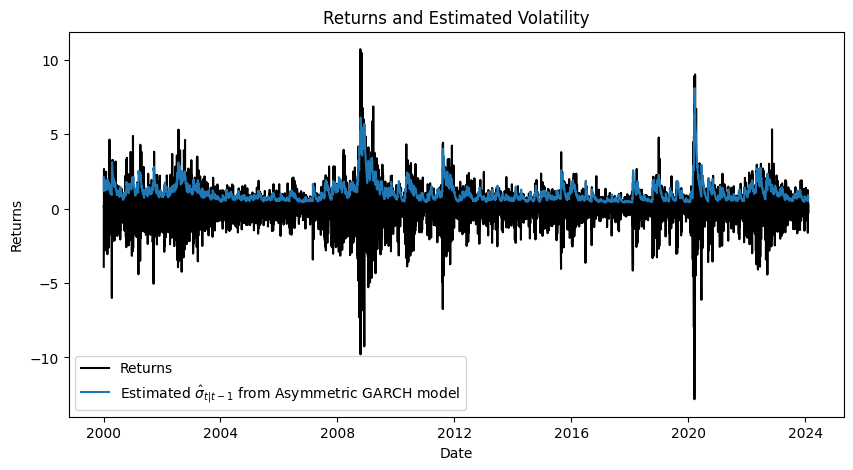

Optimization Successful: Yes
Estimated Parameters:
  mu          : 0.046
  omega       : 0.017
  alpha_pos   : 0.000
  alpha_neg   : 0.208
  beta        : 0.884
  nu          : 6.892
Log-Likelihood: -8111.4


In [7]:
# Optimization setup
initial_values = [np.mean(returns), np.var(returns) / 20, 0.10, 0.10, 0.88, 6]
bounds = [(None, None), (0, None), (0, None), (0, None), (0, None), (2, 40)]
result = optimize.minimize(neg_log_likelihood_asymmetric_garch, initial_values, args=(returns,), bounds=bounds, method='Nelder-Mead')

# Extract optimized parameters
mu_hat, omega_hat, alpha_hat_pos, alpha_hat_neg, beta_hat, nu_hat = result.x
log_likelihood = -result.fun

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(dates, returns, 'k', label='Returns')
plt.plot(dates, np.sqrt(asymmetric_garch(mu_hat, omega_hat, alpha_hat_pos, alpha_hat_neg, beta_hat, returns)), label='Estimated $\hat{\sigma}_{t|t-1}$ from Asymmetric GARCH model')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Returns and Estimated Volatility')
plt.show()

# Print results
print(f"Optimization Successful: {'Yes' if result.success else 'No'}")
print("Estimated Parameters:")
print(f"  mu          : {mu_hat:.3f}")
print(f"  omega       : {omega_hat:.3f}")
print(f"  alpha_pos   : {alpha_hat_pos:.3f}")
print(f"  alpha_neg   : {alpha_hat_neg:.3f}")
print(f"  beta        : {beta_hat:.3f}")
print(f"  nu          : {nu_hat:.3f}")
print(f"Log-Likelihood: {log_likelihood:.1f}")

# Symetric Beta-t-GARCH

/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_98953/3954052636.py:4: OptimizeWarning: Initial guess is not within the specified bounds
  result = optimize.minimize(negative_log_likelihood_asymetric_beta_t_egarch, initial_values, args=(returns,), bounds=bounds, method='Nelder-Mead')


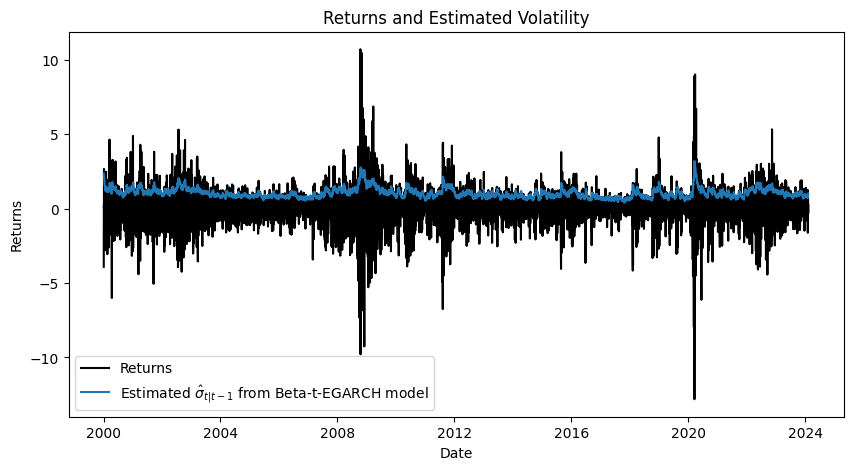

Optimization Successful: Yes
Estimated Parameters:
  mu     : 0.077
  lam    : 1.719
  phi    : 1.000
  kappa  : 0.146
  k_tilde: 0.000
  nu     : 5.495
Log-Likelihood: -8368.4


In [8]:
# Define optimization problem
initial_values = [np.mean(returns), 0, 0.95, 0.1, 0.1, 6]
bounds = [(None, None), (None, None), (0, 1), (None, None), (0, 0), (2, 40)] # Constrain kappa_tilde = 0
result = optimize.minimize(negative_log_likelihood_asymetric_beta_t_egarch, initial_values, args=(returns,), bounds=bounds, method='Nelder-Mead')

# Extract optimized parameters
mu_hat, lam_hat, phi_hat, kappa_hat, k_tilde_hat, nu_hat = result.x
log_likelihood = -result.fun

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(dates, returns, 'k', label='Returns')
plt.plot(dates, np.sqrt(asymmetric_beta_t_egarch(result.x, returns)), label='Estimated $\hat{\sigma}_{t|t-1}$ from Beta-t-EGARCH model')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Returns and Estimated Volatility')
plt.show()

# Print results
print(f"Optimization Successful: {'Yes' if result.success else 'No'}")
print("Estimated Parameters:")
print(f"  mu     : {mu_hat:.3f}")
print(f"  lam    : {lam_hat:.3f}")
print(f"  phi    : {phi_hat:.3f}")
print(f"  kappa  : {kappa_hat:.3f}")
print(f"  k_tilde: {k_tilde_hat:.3f}")
print(f"  nu     : {nu_hat:.3f}")
print(f"Log-Likelihood: {log_likelihood:.1f}")

# Asymmetric Beta-t-EGARCH,

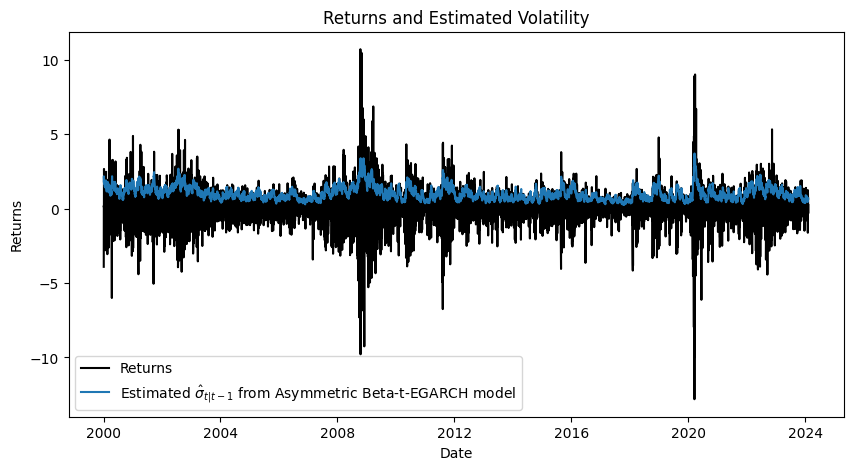

Optimization Successful: Yes
Estimated Parameters:
  mu     : 0.000
  lam    : 1.205
  phi    : 1.000
  kappa  : 0.080
  k_tilde: -0.220
  nu     : 8.264
Log-Likelihood: -8136.4


In [9]:
# Define optimization problem
initial_values = [np.mean(returns), 0, 0.95, 0.1, 0.1, 6]
bounds = [(None, None), (None, None), (0, 1), (None, None), (None, None), (2, 40)]
result = optimize.minimize(negative_log_likelihood_asymetric_beta_t_egarch, initial_values, args=(returns,), bounds=bounds, method='Nelder-Mead')

# Extract optimized parameters
mu_hat, lam_hat, phi_hat, kappa_hat, k_tilde_hat, nu_hat = result.x
log_likelihood = -result.fun

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(dates, returns, 'k', label='Returns')
plt.plot(dates, np.sqrt(asymmetric_beta_t_egarch(result.x, returns)), label='Estimated $\hat{\sigma}_{t|t-1}$ from Asymmetric Beta-t-EGARCH model')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Returns and Estimated Volatility')
plt.show()

# Print results in a structured format
print(f"Optimization Successful: {'Yes' if result.success else 'No'}")
print("Estimated Parameters:")
print(f"  mu     : {mu_hat:.3f}")
print(f"  lam    : {lam_hat:.3f}")
print(f"  phi    : {phi_hat:.3f}")
print(f"  kappa  : {kappa_hat:.3f}")
print(f"  k_tilde: {k_tilde_hat:.3f}")
print(f"  nu     : {nu_hat:.3f}")
print(f"Log-Likelihood: {log_likelihood:.1f}")